In [80]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Loading Dataset

In [81]:
# Function to load MRI images
def load_mri_images(subject_number):
    base_dir = '/gpfs/scratch/pa2297/Dataset/BraTS2021_Test'
    folder_name = f"BraTS2021_{subject_number:05d}"
    images = {}
    
    for img_type in ['flair', 't1', 't1ce', 't2']:
        file_path = os.path.join(base_dir, folder_name, f"{folder_name}_{img_type}.nii.gz")
        if os.path.exists(file_path):
            images[img_type] = nib.load(file_path)
        else:
            print(f"File not found: {file_path}")
    
    return images

In [82]:
subject_number = 636  # Replace this with the actual subject number you want to access
data = load_mri_images(subject_number)

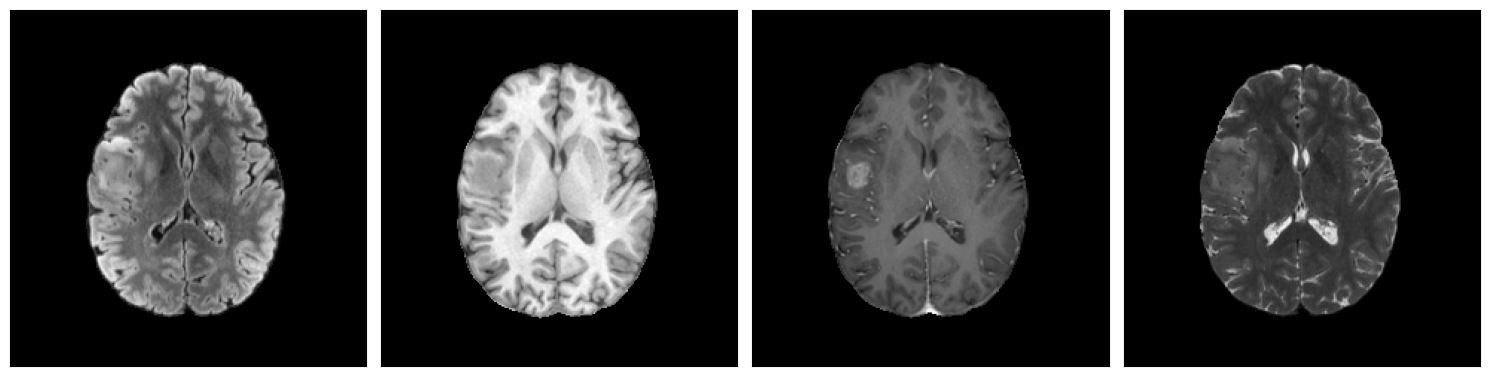

In [84]:
import numpy as np
import matplotlib.pyplot as plt

images = {
    'T2-FLAIR': data['flair'].get_fdata(),
    'T1-weighted': data['t1'].get_fdata(),
    'T1Gd': data['t1ce'].get_fdata(),
    'T2-weighted': data['t2'].get_fdata()
}

slice_index = 81

# Create a figure 
fig, axes = plt.subplots(1, 4, figsize=(15, 8)) 

# Loop through each image and plot it in a subplot
for i, (key, image) in enumerate(images.items()):
    # Assuming images are 2D, we take the middle slice if they are 3D
    image_slice = image[:, :, slice_index]
    # Rotate the image slice 90 degrees clockwise
    rotated_image = np.rot90(image_slice, k=-1)
    ax = axes[i]
    im = ax.imshow(rotated_image, cmap='gray')
    # ax.set_title(key, fontweight='bold')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Optional: Remove the ticks as well
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [6]:
def load_constraint_map(subject_number, base_dir):
    folder_name = f"BraTS2021_{subject_number:05d}"
    mat_file_path = os.path.join(base_dir, folder_name, 'Constraint_map_20.mat')
    
    if os.path.exists(mat_file_path):
        data = loadmat(mat_file_path)
        print(f"Successfully loaded {mat_file_path}")
        return data
    else:
        print(f"File not found: {mat_file_path}")
        return None

In [22]:
dir2 = '/gpfs/scratch/pa2297/CM/t1-t2-tce-flair/Constraint_Maps'
cluster2 = load_constraint_map(subject_number, dir2)
map2 = cluster2['param']

Successfully loaded /gpfs/scratch/pa2297/CM/t1-t2-tce-flair/Constraint_Maps/BraTS2021_00709/Constraint_map_20.mat


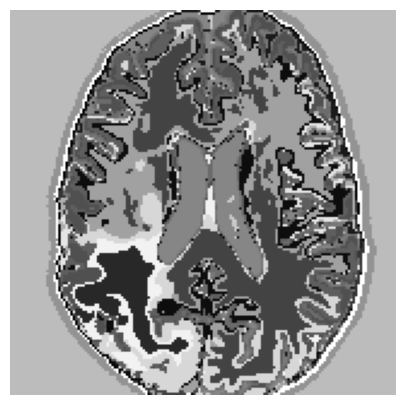

In [23]:
import matplotlib.pyplot as plt

# Assuming map2 and slice_index are defined as per your context
fig, ax = plt.subplots(figsize=(10, 5))

# Plot T1 channel
ax.imshow(map2[:, :, slice_index], cmap='gray')
# ax.set_title('CM: t2, flair')
ax.axis('off')  # This will remove the axis

plt.show()

# Visualizing Predictions

In [1]:
import sys
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import tensorflow as tf
import scipy.io as sio



sys.path.append('/gpfs/scratch/pa2297/CCL-Synthetis/')


import Synthesis.synth_config as cfg

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n95uraue because the default path (/gpfs/home/pa2297/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-05-14 21:50:36.565805: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 21:50:37.783245: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 21:50:37.784350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 21:50:46.307237: W tensorflow/compile

In [2]:
'''Loading Test subject'''

sys.path.append('/gpfs/scratch/pa2297/multi-contrast-contrastive-learning/')

from utils.utils import myCrop3D
from utils.utils import contrastStretch
from skimage import exposure

In [3]:
def normalize_img_zmean(img, mask):
    ''' Zero mean unit standard deviation normalization based on a mask'''
    mask_signal = img[mask>0]
    mean_ = mask_signal.mean()
    std_ = mask_signal.std()
    img = (img - mean_ )/ std_
    return img, mean_, std_

def normalize_img(img):
    img = (img - img.min())/(img.max()-img.min())
    return img


def load_subject(datadir, subName):
    data_suffix = ['_t1ce.nii.gz', '_t2.nii.gz', '_t1.nii.gz', '_flair.nii.gz']
    sub_img = []
    mask = None
    for suffix in data_suffix:
        img_path = f"{datadir}{subName}/{subName}{suffix}"
        img_data = nib.load(img_path).get_fdata()
        img_data = np.rot90(img_data, -1)
        img_data = myCrop3D(img_data, (192,192))

        if mask is None:  
            mask = np.zeros(img_data.shape)
            mask[img_data > 0] = 1
        
        img_data = contrastStretch(img_data, mask, 0.01, 99.9)
        img_data, mean_, std_ = normalize_img_zmean(img_data, mask)
        # img_data = normalize_img(img_data)
        sub_img.append(img_data)
    
    sub_img = np.stack(sub_img, axis=-1)
    sub_img = np.transpose(sub_img, (2,0,1,3))  # Adjust dimensions as needed
    sub_img = sub_img[40:120]  # Assuming your volume z-axis slice range
    print(sub_img.shape)

    
    return sub_img

# Example usage
datadir = "/gpfs/scratch/pa2297/Dataset/BraTS2021_Test/"
subName = 'BraTS2021_00618'  # Replace with actual subject names retrieval logic
#1194
img = load_subject(datadir, subName)
 

(80, 192, 192, 4)


In [4]:
# Loading the test set

def get_data(img, contrast_idx, target_contrast_idx):
    """Returns tuple (input, target) correspond to sample #idx."""
    x_train = generate_X(img, contrast_idx)
    y_train = generate_Y(img, target_contrast_idx)
    return tf.identity(x_train), tf.identity(y_train)
        
def generate_X(img, contrast_idx):    
    X = img[..., contrast_idx]
    return X
    
def generate_Y(img, target_contrast_idx):    
    Y = img[..., target_contrast_idx] 
    return Y

a,b = get_data(img, cfg.contrast_idx, cfg.target_contrast_idx)

2024-05-14 21:51:04.672859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
def load_predictions(predictions_file):
    data = sio.loadmat(predictions_file)
    return data

predictions_file = '/YourPath/BraTS2021_00618_predictions.mat'
#Flair10-loss5
data = load_predictions(predictions_file)

predictions = {
    'Baseline': data['predictions']['Baseline'][0, 0],
    'Partial_Decoder': data['predictions']['Partial_Decoder'][0, 0],
    'Full_Decoder': data['predictions']['Full_Decoder'][0, 0]
}


In [9]:
def plot_model_predictions(predictions, slice_index, original_img=None):
    # Determine the number of subplots based on whether there's an original image
    num_models = len(predictions)
    if original_img is not None:
        num_models += 1
    
    # Set up the plotting figure
    fig, axes = plt.subplots(1, num_models, figsize=(15, 5))
    
    # Plot original image first if provided
    if original_img is not None:
        axes[0].imshow(original_img[slice_index, :, :,0], cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')
    
    # Plot each model's prediction
    for i, (model_name, model_prediction) in enumerate(predictions.items(), start=1 if original_img is not None else 0):
        axes[i].imshow(model_prediction[slice_index, :, :,0], cmap='gray')
        axes[i].set_title(model_name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

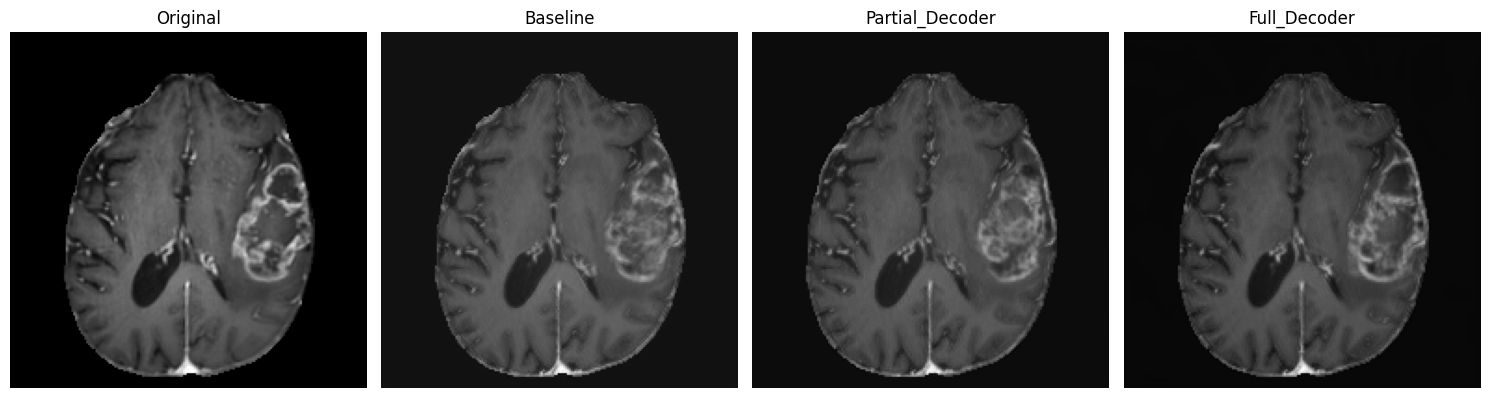

In [10]:
# Assume you have a 3D array for the original image
original_img = b   # Replace with your actual 3D image array

# Example slice index to display
slice_index = 34
#15

# Plot predictions
plot_model_predictions(predictions, slice_index, original_img=original_img)